In [45]:
# This code produces one SHFT per raw data column in each raw datafile.
# This was later automated to go through the entire folder of raw data. Given this was created on google collab for sharing purposes this shows how a single SHFT was created for simplicity.

import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from google.colab import drive
!pip install -q matplotlib nbconvert
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os


drive.mount("/content/drive") # Where the file was mounted

%cd /content/drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


# Selecting the Raw Data File

In [46]:
dataset = pd.read_csv('JasmanMaze.csv')
dataset = dataset.drop(0) # Re-formatting as the first row yield errors.
dataset.head(1)

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
1,2023-11-21 21:30:04.261,1.004865,0.642882,0.996166,1.095969,0.431255,0.447909,0.309179,1.191004,0.407657,...,4.209442,-4.164581,-0.650482,1.0,1.0,1.0,1.0,1.0,40.0,NaN


# Cleaning Out the NaN values TP9, AF7, AF8 and TP10.

In [47]:
if dataset['RAW_TP9'].isnull().any():
    print("Warning: NaN values found in the 'Data' column. Please handle or remove them.")
    dataset = dataset.dropna(subset=['RAW_TP9']) # Must change the column name to the other raw data to generate 4 complete SHFTs per raw data file.


In [48]:
if dataset['RAW_AF7'].isnull().any():
    print("Warning: NaN values found in the 'Data' column. Please handle or remove them.")
    dataset = dataset.dropna(subset=['RAW_AF7']) # Must change the column name to the other raw data to generate 4 complete SHFTs per raw data file.

In [49]:
if dataset['RAW_AF8'].isnull().any():
    print("Warning: NaN values found in the 'Data' column. Please handle or remove them.")
    dataset = dataset.dropna(subset=['RAW_AF8']) # Must change the column name to the other raw data to generate 4 complete SHFTs per raw data file.

In [50]:
if dataset['RAW_TP10'].isnull().any():
    print("Warning: NaN values found in the 'Data' column. Please handle or remove them.")
    dataset = dataset.dropna(subset=['RAW_TP10']) # Must change the column name to the other raw data to generate 4 complete SHFTs per raw data file.

# Creating a New Subset of The Data That We Are Interested In

In [51]:
X = dataset.iloc[:,[21,22,23,24]]
X.head()
print(X.shape)

(18096, 4)


#Creating a Time Series Graph for Validation

<ipython-input-52-41196e1fd500>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['TimeStamp'] = pd.to_datetime(dataset['TimeStamp'], format='%Y-%m-%d %H:%M:%S.%f')


Text(0, 0.5, 'Amplitude')

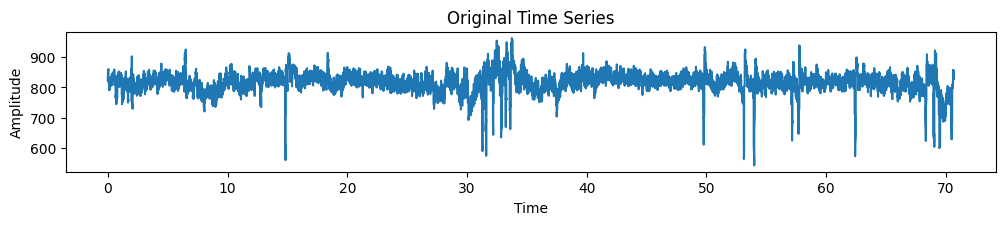

In [52]:
dataset['TimeStamp'] = pd.to_datetime(dataset['TimeStamp'], format='%Y-%m-%d %H:%M:%S.%f')
time_diff = (dataset['TimeStamp'] - dataset['TimeStamp'].iloc[0]).dt.total_seconds()
X = X.values
k=0; # MUST CHANGE VALUE OF K FROM 0 THROUGH 3 to generate all 4 SHFTs. Then change file name to the next 12 files.
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(time_diff, X[:,k])
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# This was created to inspect if the time series looked somewhat normal. Helps with debugging.

In [53]:
print(X.shape)

(18096, 4)


# Cleaning Out More Data For other Columns. K represents one of the Raw Data Columns


In [54]:
valid_indices = ~np.isnan(X[:,k])
X = X[valid_indices]
time_diff=time_diff.values

In [55]:
nan_mask = np.isnan(time_diff)

if np.any(nan_mask):
    print("Warning: NaN values found in the 'Data' column. Please handle or remove them.")
    data = time_diff[~nan_mask]


In [56]:
print(X.shape)

(18096, 4)


# Generates the FFT

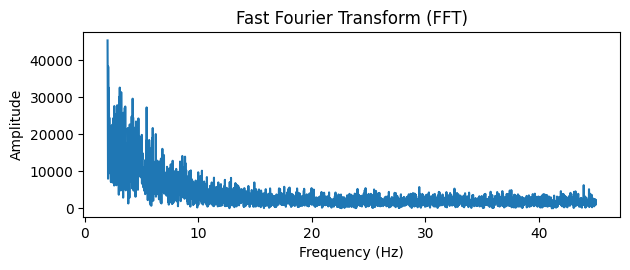

In [57]:
# This takes the valid time series data and converts that into an FTT. This was a method that could have been used instead of SHFTs
fft_result = np.fft.fft(X[:,k])
avg_time_diff = np.mean(np.diff(time_diff))
sampling_rate = 1 / avg_time_diff # How the sampling rate was determined.
fft_freq = np.fft.fftfreq(len(fft_result), 1/sampling_rate)

plt.subplot(2, 1, 2)
plt.plot(fft_freq[(fft_freq >= 2) & (fft_freq <= 45)], np.abs(fft_result[(fft_freq >= 2) & (fft_freq <= 45)])) # This limits the band of frequencies.
plt.title('Fast Fourier Transform (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


# Creating the SHFT

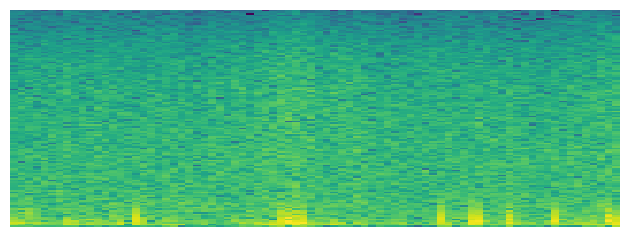

In [58]:
# The SHFT was what the actual CNN model took as input. Titles and labels were edited out to make it easier.
from scipy.signal import spectrogram
frequencies, times, Sxx = spectrogram(X[:,k], fs=sampling_rate)
plt.subplot(2, 1, 2)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')  # Shading was played around with later on to make the changes more recongizable.
plt.axis('off')
plt.tight_layout()

# File path was created below and this again is an example because of google collab.

#save_path = '/content/gdrive/My Drive/Your_Folder_Name/your_plot.png'
#plt.savefig(save_path)
plt.show()

This code was then exported and used with a loop to automate the process since many SHFTs were required. The SHFT above is an example of what the CNN model took as input. This was then used to determine if the task was recall or problem solving task.